<a href="https://www.kaggle.com/code/mahendra77/emotion-analysis?scriptVersionId=160220329" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**In This Notebook**
1. Learn about the Evolution of  Text processing in NLP
2. Performs Sentiment (OR) Emotion Analysis On Sample Data

## Import Necessary Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention,Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D,GRU, Dropout

# train-test-validation
from sklearn.model_selection import train_test_split


## metrics
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Dataset Overview

In [2]:
data=pd.read_csv('/kaggle/input/emotion-textual-data/Data (1).csv',encoding='unicode_escape')

In [3]:
## info about datset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


**Emotion is Target Label**

In [4]:
## shape of the Data
records ,features = data.shape
print(f'Data Contains {records} rows and {features} columns')

Data Contains 5937 rows and 2 columns


In [5]:
## Top-5 rows of Data
data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [6]:
## Bottom-5 Rows of Data
data.tail()

,Comment,Emotion
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear
5936,i just wanted to apologize to you because i fe...,anger


In [7]:
## check Null Values
data.isnull().sum()

Comment    0
Emotion    0
dtype: int64

In [8]:
## Check if Data contains Duplicates rows
data.duplicated().sum()

0

<Axes: xlabel='Emotion', ylabel='count'>

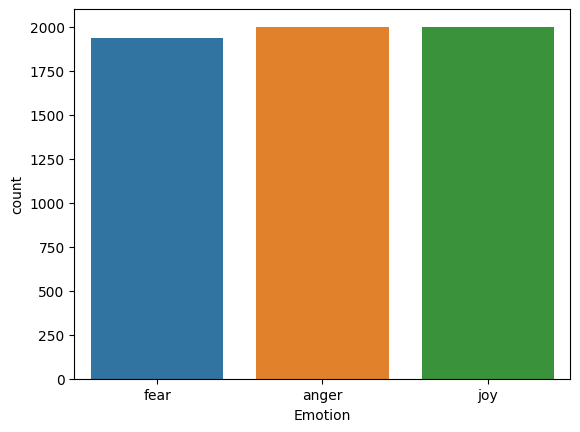

In [9]:
## Check if data Unbalnced
'''
Unbalnced Dataset means that One Class of Target label Dominates Rest of the Classes.
'''
sns.countplot(x='Emotion',data=data)

**Dataset Summary:**
1. No Null Values.
2. No Redundancy.
3. Dataset is Balanced.

## Data Cleaning

In [10]:
## Not used NLTK for Simplicity
## domian stop words 

stop_words = [
               'for','you','and','there','are','was','were','them','they',
               'that','this','one','here','because'
             ]

In [11]:
import re

def clean_text(text):
    
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and punctuation
    text = re.sub('[^a-zA-Z0-9\s]', '', text)

    # Remove numbers 
    text = re.sub('\d+', '', text)

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()
    
    # stop-words
    text = ' '.join([word for word in text.split() if len(word)>2 and word not in stop_words])
    return text

data['Comment']=data['Comment'].apply(clean_text)

In [12]:
data['Emotion'] = data['Emotion'].map({'fear':0,'anger':1,'joy':2})
data['Emotion'].astype(dtype="category")

0       0
1       1
2       0
3       2
4       0
       ..
5932    0
5933    1
5934    2
5935    0
5936    1
Name: Emotion, Length: 5937, dtype: category
Categories (3, int64): [0, 1, 2]

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Comment'],data['Emotion'], test_size=0.25, random_state=42)

In [14]:
# fit of model
def fit_model(model,X,y,epochs=10):
    '''
     Training Model.
    '''
    # Compile the model
    model.compile(optimizer='rmsprop', loss = "sparse_categorical_crossentropy", metrics=['accuracy'])
    # Train the model
    model.fit(X, y, epochs = epochs, batch_size=32, validation_split=0.2)

# accuracy of model
def accuracy_(model,X,y):
    '''
     Function used to Provide Accuracy.
    '''
    loss, accuracy = model.evaluate(X, y)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%") 
    

## detailed report
def report(y,y_pred):
    
    print(classification_report(y,y_pred))
    cm = confusion_matrix(y,y_pred)
    
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ['fear','anger','joy']).plot()

**Bag Of Words**
> The bag of words model is a simple document embedding technique based on word frequency. Conceptually, we think of the whole document as a “bag” of words, rather than a sequence. We represent the document simply by the frequency of each word. For example, if we have a vocabulary of 1000 words, then the whole document will be represented by a 1000-dimensional vector, where the vector’s ith entry represents the frequency of the ith vocabulary word in the document.

![](https://user.oc-static.com/upload/2022/12/08/16705125107088_16034397439042_surfin%20bird%20bow.png)

**Pros**<br>
    Ease of Future Engineering<br>
    Simplicity
 
**Cons**<br>
    Loss of context<br>
    Lack of Semantic Representation<br>
    Limited ability to handle rare words
    

**TF-IDF**
> It measures how important a term is within a document relative to a collection of documents.The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Xw19xjYH_oyaIoX2znlPjw.png)

**Pros**<br>
    Handles stop words<br>
    
**Cons**<br>
    Ignores the context<br>
    Assumes independence<br>
    Ignores Word Order

**One Hot Encoding**:- 
>     It is Vector Representation of words in a Vocabulry.Every word (even symbols) which are part of the Vocabulry are written in the form of vectors, constituting only of 1 and 0 . So one hot vector is a vector whose elements are only 1 and 0.

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*_da_YknoUuryRheNS-SYWQ.png)
   
   In the image above :- ‘The’ and ‘the’ have different encoding implying they are different. Thus we are representing every word and symbols in the text data as a unique one hot vector which contains numerical data(1 and 0) as its constituent elements. One word is represented as a vector therefore the list of words in the sentence can be represented as an array of vectors or a matrix and if we have list of sentences whose words are one hot encoded then it will result in an array whose elements are matrices. So we end up with a three dimensional tensor which can be fed to the Neural network.
   
   **Pros**
       Highly intutive and Staright Forward.
   
   **Cons**<br>
       Memory InEfficient.<br>
       Word Similarity Context not defined.

**Word2Vec**
> It is a two-layer neural network that processes text by vectorizing words. It Encodes each word in vector and trains words against other neightbouring words in corpus. It is used to predict a word or word Context.

**Pros**<br>
    Retains Context
**Cons**<br>
    Difficult to Train

**Embedding Layer** Can be used to Create Word Embeddings
> The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).


**GloVe Embeddings** are a type of word embedding that encode the co-occurrence probability ratio between two words as vector differences.

### TF-IDF

In [15]:
# Create a TF-IDF representation of the text data
vectorizer = TfidfVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Convert the sparse matrix to a dense array
X_train_dense = X_train_bow.toarray()
X_test_dense = X_test_bow.toarray()

# Tokenize the text and pad sequences for LSTM
max_words = 2000
max_sequence_length = X_train_dense.shape[1]

# Build LSTM model
embedding_dim = 150  # Adjust based on your dataset
model = Sequential()
model.add(Dense(256,input_shape = (max_sequence_length,),activation ='relu'))
model.add(Dense(3, activation='softmax'))  # Assuming three classes (positive, neutral, negative)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1906688   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1907459 (7.28 MB)
Trainable params: 1907459 (7.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# fit
fit_model(model,X_train_dense,y_train)

# Evaluate the model
accuracy_(model,X_test_dense,y_test)

Epoch 1/10
112/112 [==============================] - 2s 6ms/step - loss: 1.0203 - accuracy: 0.6434 - val_loss: 0.8868 - val_accuracy: 0.7576
Epoch 2/10
112/112 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.9202 - val_loss: 0.5402 - val_accuracy: 0.9046
Epoch 3/10
112/112 [==============================] - 0s 3ms/step - loss: 0.2920 - accuracy: 0.9666 - val_loss: 0.3470 - val_accuracy: 0.9091
Epoch 4/10
112/112 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9812 - val_loss: 0.2712 - val_accuracy: 0.9203
Epoch 5/10
112/112 [==============================] - 0s 4ms/step - loss: 0.0730 - accuracy: 0.9879 - val_loss: 0.2381 - val_accuracy: 0.9181
Epoch 6/10
112/112 [==============================] - 0s 4ms/step - loss: 0.0463 - accuracy: 0.9927 - val_loss: 0.2302 - val_accuracy: 0.9226
Epoch 7/10
112/112 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 0.9952 - val_loss: 0.2224 - val_accuracy: 0.9237
Epoch 

47/47 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       505
           1       0.93      0.94      0.93       497
           2       0.92      0.95      0.93       483

    accuracy                           0.93      1485
   macro avg       0.93      0.93      0.93      1485
weighted avg       0.93      0.93      0.93      1485



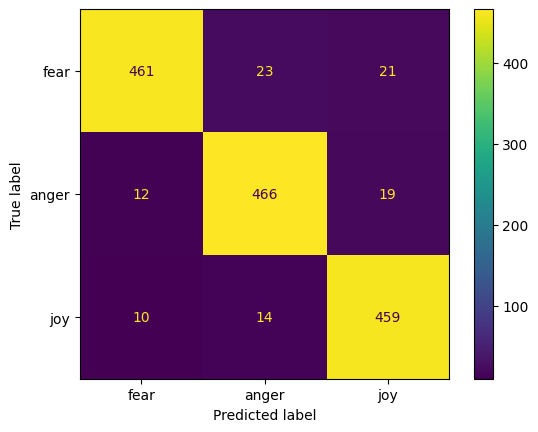

In [17]:
report(y_test,np.argmax(model.predict(X_test_dense),axis=1))

#### LSTM 

In [18]:
## prepare data as Sequences
tokenizer = Tokenizer(num_words=max_words,oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(len(seq) for seq in sequences_train)
X_train_lstm = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_test_lstm = pad_sequences(sequences_test, maxlen=max_sequence_length)

In [19]:
w_id = tokenizer.word_index
max_words = len(w_id)

In [20]:
## model creation
model = Sequential()

embedding_dim = 100
## embedding layer to process text
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))

## using LSTM -- recurrent Cell
model.add(LSTM(512,activation='relu'))

## output layer
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 100)           744800    
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2001763 (7.64 MB)
Trainable params: 2001763 (7.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# fit
fit_model(model,X_train_lstm,y_train)

# Evaluate the model
accuracy_(model,X_test_lstm,y_test)

Epoch 1/10
112/112 [==============================] - 18s 143ms/step - loss: 1.0949 - accuracy: 0.3656 - val_loss: 1.0816 - val_accuracy: 0.4512
Epoch 2/10
112/112 [==============================] - 10s 93ms/step - loss: 0.9338 - accuracy: 0.6313 - val_loss: 0.7105 - val_accuracy: 0.7710
Epoch 3/10
112/112 [==============================] - 8s 69ms/step - loss: 0.3986 - accuracy: 0.9085 - val_loss: 0.2446 - val_accuracy: 0.9248
Epoch 4/10
112/112 [==============================] - 8s 72ms/step - loss: 0.1669 - accuracy: 0.9548 - val_loss: 1.4977 - val_accuracy: 0.9237
Epoch 5/10
112/112 [==============================] - 8s 66ms/step - loss: 0.1009 - accuracy: 0.9733 - val_loss: 0.1994 - val_accuracy: 0.9371
Epoch 6/10
112/112 [==============================] - 7s 63ms/step - loss: 0.0726 - accuracy: 0.9792 - val_loss: 0.1952 - val_accuracy: 0.9405
Epoch 7/10
112/112 [==============================] - 7s 67ms/step - loss: 0.0551 - accuracy: 0.9848 - val_loss: 0.1699 - val_accuracy: 0.9

### GRU

In [22]:
## model creation
model = Sequential()

embedding_dim = 150

## embedding layer to process text
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))

## using GRU -- recurrent Cell
model.add(GRU(512,activation='relu'))

## output layer
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 150)           1117200   
                                                                 
 gru (GRU)                   (None, 512)               1019904   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2138643 (8.16 MB)
Trainable params: 2138643 (8.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# fit
fit_model(model,X_train_lstm,y_train)

# Evaluate the model
accuracy_(model,X_test_lstm,y_test)

Epoch 1/10
112/112 [==============================] - 19s 154ms/step - loss: 1.0871 - accuracy: 0.3993 - val_loss: 1.0810 - val_accuracy: 0.3423
Epoch 2/10
112/112 [==============================] - 12s 110ms/step - loss: 0.7397 - accuracy: 0.7091 - val_loss: 0.5110 - val_accuracy: 0.8260
Epoch 3/10
112/112 [==============================] - 11s 97ms/step - loss: 0.2704 - accuracy: 0.9231 - val_loss: 0.2155 - val_accuracy: 0.9282
Epoch 4/10
112/112 [==============================] - 10s 88ms/step - loss: 0.1334 - accuracy: 0.9635 - val_loss: 0.2078 - val_accuracy: 0.9315
Epoch 5/10
112/112 [==============================] - 9s 83ms/step - loss: 0.0875 - accuracy: 0.9744 - val_loss: 0.2427 - val_accuracy: 0.9259
Epoch 6/10
112/112 [==============================] - 10s 85ms/step - loss: 0.0612 - accuracy: 0.9815 - val_loss: 0.1945 - val_accuracy: 0.9450
Epoch 7/10
112/112 [==============================] - 9s 82ms/step - loss: 0.0500 - accuracy: 0.9857 - val_loss: 0.1776 - val_accuracy:

### Hyper Parameter Tuning

In [24]:
# Assume X_train, y_train, X_val, y_val are your training and validation data
X_train_, X_val, y_train_,y_val = train_test_split(X_train_lstm,y_train,test_size=0.2,random_state =23)

In [25]:
import keras_tuner as kt

def build_gru_model(hp):
    model = Sequential()
    
    model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_sequence_length))

    model.add(GRU(units=hp.Int('units', min_value=128, max_value=512, step=32),))
              
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=3, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss= "sparse_categorical_crossentropy",
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband( build_gru_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [26]:
tuner.search(X_train_, y_train_, epochs=20, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

Trial 30 Complete [00h 00m 27s]
val_accuracy: 0.9618406295776367

Best val_accuracy So Far: 0.9708192944526672
Total elapsed time: 00h 09m 32s
Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fb269bbb130>


In [27]:
tuner.get_best_hyperparameters(num_trials=1)[0].values

{'units': 224,
 'dropout_rate': 0.30000000000000004,
 'learning_rate': 0.003533627817437416,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

### GRU With Glove 6B

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-01-24 07:40:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-24 07:40:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-24 07:40:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [29]:
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() 
        word2vector = {}
        for line in f:
            line_ = line.strip() 
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [30]:
vocab, word_to_idx =read_data("glove.6B.100d.txt")

Total Words in DataSet: 400000


In [31]:
embedding_matrix = np.zeros((len(w_id) + 1, 100))
for word, i in w_id.items():
    embedding_vector = word_to_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
## model creation
model = Sequential()
embedding_dim = 100
## embedding layer to process text

model.add(Embedding(input_dim=max_words+1, output_dim=embedding_dim, input_length=max_sequence_length,weights=[embedding_matrix],trainable=False))

## GRU
model.add(GRU(512,activation='relu'))

## output layer
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 100)           744900    
                                                                 
 gru_1 (GRU)                 (None, 512)               943104    
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 1689543 (6.45 MB)
Trainable params: 944643 (3.60 MB)
Non-trainable params: 744900 (2.84 MB)
_________________________________________________________________


In [33]:
# fit
fit_model(model,X_train_lstm,y_train)

# Evaluate the model
accuracy_(model,X_test_lstm,y_test)

Epoch 1/10
112/112 [==============================] - 10s 75ms/step - loss: 0.8790 - accuracy: 0.5906 - val_loss: 0.6792 - val_accuracy: 0.6756
Epoch 2/10
112/112 [==============================] - 8s 72ms/step - loss: 0.4478 - accuracy: 0.8461 - val_loss: 0.3844 - val_accuracy: 0.8519
Epoch 3/10
112/112 [==============================] - 8s 72ms/step - loss: 0.2586 - accuracy: 0.9107 - val_loss: 0.2054 - val_accuracy: 0.9315
Epoch 4/10
112/112 [==============================] - 8s 75ms/step - loss: 0.1687 - accuracy: 0.9402 - val_loss: 0.2015 - val_accuracy: 0.9248
Epoch 5/10
112/112 [==============================] - 8s 73ms/step - loss: 0.1215 - accuracy: 0.9587 - val_loss: 0.1190 - val_accuracy: 0.9484
Epoch 6/10
112/112 [==============================] - 8s 73ms/step - loss: 0.0872 - accuracy: 0.9711 - val_loss: 0.1915 - val_accuracy: 0.9371
Epoch 7/10
112/112 [==============================] - 8s 73ms/step - loss: 0.0639 - accuracy: 0.9789 - val_loss: 0.0983 - val_accuracy: 0.960

47/47 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       505
           1       0.92      0.98      0.95       497
           2       0.98      0.96      0.97       483

    accuracy                           0.96      1485
   macro avg       0.96      0.96      0.96      1485
weighted avg       0.96      0.96      0.96      1485



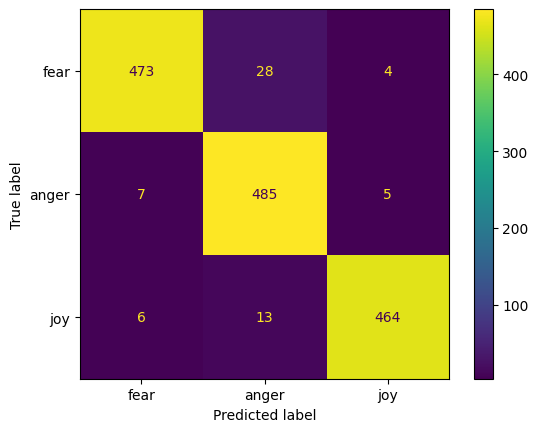

In [34]:
report(y_test,np.argmax(model.predict(X_test_lstm),axis=1))

### Attention Mechanism + LSTM

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model

# Define the model architecture
def create_attention_model(input_dim, output_dim, embed_dim, lstm_units):
    # Input layer
    input_layer = Input(shape=(None,))

    # Embedding layer
    embedding_layer = Embedding(input_dim=input_dim, output_dim=embed_dim)(input_layer)

    # LSTM layer
    lstm_layer = LSTM(units=lstm_units)(embedding_layer)

    # Attention layer
    attention_layer = Attention()([lstm_layer, lstm_layer])

    # Apply attention to LSTM output
    attended_layer = tf.keras.layers.Dot(axes=(1, 1))([attention_layer, lstm_layer])

    # Dense layer for final prediction
    output_layer = Dense(output_dim, activation='softmax')(attended_layer)

    # Model creation
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


# Create the model
model = create_attention_model(max_words+1, 3, 100, 256)

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 100)            744900    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 256)                  365568    ['embedding_2[0][0]']         
                                                                                                  
 attention (Attention)       (None, 256)                  0         ['lstm[0][0]',                
                                                                     'lstm[0][0]']            

In [36]:
# fit
fit_model(model,X_train_lstm,y_train,30)

# Evaluate the model
accuracy_(model,X_test_lstm,y_test)

Epoch 1/30
112/112 [==============================] - 11s 82ms/step - loss: 1.1026 - accuracy: 0.3401 - val_loss: 1.0992 - val_accuracy: 0.3412
Epoch 2/30
112/112 [==============================] - 4s 33ms/step - loss: 1.0970 - accuracy: 0.3406 - val_loss: 1.0973 - val_accuracy: 0.3569
Epoch 3/30
112/112 [==============================] - 2s 19ms/step - loss: 1.0892 - accuracy: 0.3892 - val_loss: 1.0810 - val_accuracy: 0.4343
Epoch 4/30
112/112 [==============================] - 2s 20ms/step - loss: 1.0394 - accuracy: 0.4693 - val_loss: 1.0183 - val_accuracy: 0.5567
Epoch 5/30
112/112 [==============================] - 2s 14ms/step - loss: 0.9338 - accuracy: 0.5751 - val_loss: 0.9061 - val_accuracy: 0.5825
Epoch 6/30
112/112 [==============================] - 1s 13ms/step - loss: 0.8307 - accuracy: 0.6394 - val_loss: 0.8585 - val_accuracy: 0.6117
Epoch 7/30
112/112 [==============================] - 1s 7ms/step - loss: 0.7500 - accuracy: 0.6905 - val_loss: 0.8070 - val_accuracy: 0.7205

47/47 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       505
           1       0.76      0.95      0.84       497
           2       0.95      0.87      0.90       483

    accuracy                           0.88      1485
   macro avg       0.89      0.88      0.88      1485
weighted avg       0.89      0.88      0.88      1485



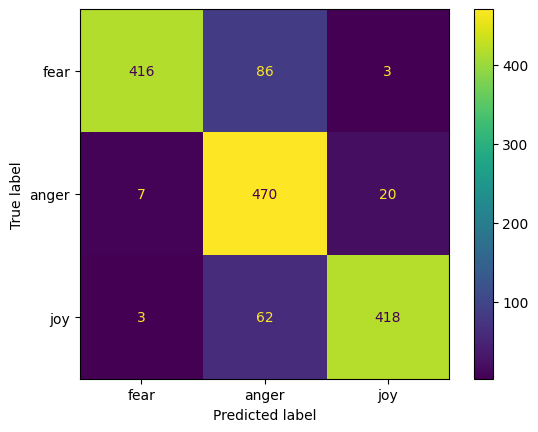

In [37]:
report(y_test,np.argmax(model.predict(X_test_lstm),axis=1))

#### Transformers

In [38]:
X_train,X_val,y_train,y_val =train_test_split(X_train,y_train,train_size=0.15,random_state=12)

In [39]:
from transformers import BertTokenizer,TFBertForSequenceClassification
import tensorflow as tf
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize the texts
tokenized_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
tokenized_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='tf')
tokenized_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [40]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_train['input_ids'],
        'attention_mask': tokenized_train['attention_mask'],
        'token_type_ids': tokenized_train['token_type_ids'],
    },
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_val['input_ids'],
        'attention_mask': tokenized_val['attention_mask'],
        'token_type_ids': tokenized_val['token_type_ids'],
    },
    y_val
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': tokenized_test['input_ids'],
        'attention_mask': tokenized_test['attention_mask'],
        'token_type_ids': tokenized_test['token_type_ids'],
    },
    y_test
))

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [41]:
# Load pre-trained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Fine-tune the model on your sentiment dataset
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
21/21 [==============================] - 67s 926ms/step - loss: 1.0867 - accuracy: 0.3973 - val_loss: 1.0244 - val_accuracy: 0.5812
Epoch 2/10
21/21 [==============================] - 16s 760ms/step - loss: 0.8997 - accuracy: 0.6432 - val_loss: 0.7610 - val_accuracy: 0.7392
Epoch 3/10
21/21 [==============================] - 15s 729ms/step - loss: 0.5326 - accuracy: 0.8321 - val_loss: 0.4717 - val_accuracy: 0.8491
Epoch 4/10
21/21 [==============================] - 15s 730ms/step - loss: 0.2397 - accuracy: 0.9415 - val_loss: 0.3381 - val_accuracy: 0.8906
Epoch 5/10
21/21 [==============================] - 15s 729ms/step - loss: 0.1011 - accuracy: 0.9820 - val_loss: 0.3629 - val_accuracy: 0.8925
Epoch 6/10
21/21 [==============================] - 14s 683ms/step - loss: 0.0377 - accuracy: 0.9970 - val_loss: 0.3296 - val_accuracy: 0.9059
Epoch 7/10
21/21 [==============================] - 14s 690ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.3638 - val_accuracy: 0.9030

In [42]:
model.evaluate(test_dataset)

47/47 [==============================] - 8s 98ms/step - loss: 0.3436 - accuracy: 0.9138


[0.3436467945575714, 0.9138047099113464]